[decomposed] n=514506 p50=2,275 p90=9,168 p95=13,566 p99=17,874 p99.9=38,164 max=652,013
  > 2,048 tokens: 52.7%
  > 4,096 tokens: 31.3%
  > 8,192 tokens: 11.8%
  > 16,384 tokens: 1.5%


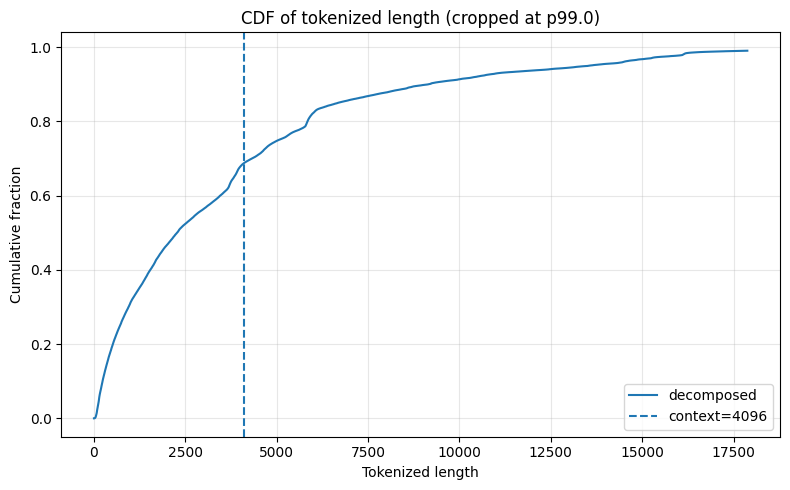

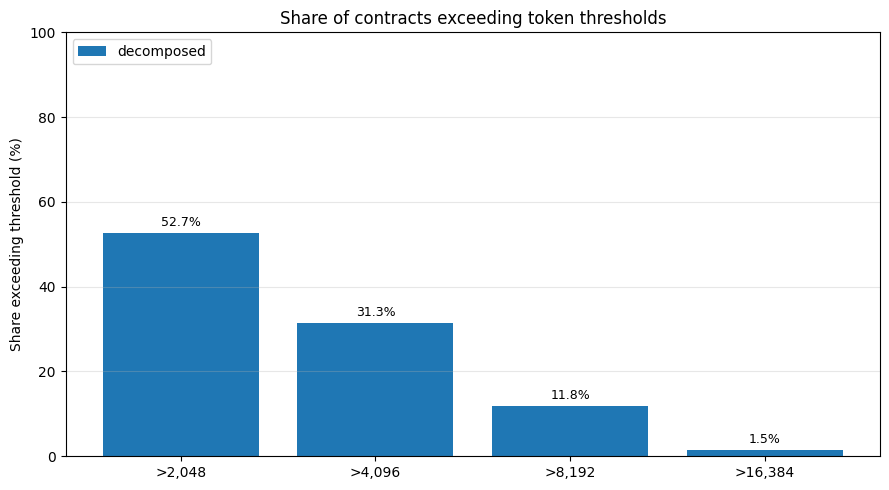

In [1]:
# %%
"""
DISL token-length visualization (notebook-friendly)

This cell:
  - Loads per-row token lengths from your persisted files: disl_token_stats/lengths_<config>.bin
  - Computes compact stats (n, p50/p90/p95/p99/p99.9)
  - Plots:
      (A) CDF cropped at the 99th percentile (so the main mass is readable)
          with a vertical line at context window (e.g., 4,096)
      (B) Grouped bars showing fraction of rows exceeding thresholds (2k/4k/8k/16k)

Assumptions:
  - You already ran the full-pass script and produced:
        disl_token_stats/lengths_<config>.bin
  - Each .bin contains uint32 token lengths, one per row

Edit CONFIGS / OUTPUT_DIR / THRESHOLDS below to match your run.
"""

import os
import json
import numpy as np
import matplotlib.pyplot as plt

# ---------- Utilities ----------

def load_lengths_bin(bin_path: str) -> np.ndarray:
    """Load uint32 lengths from .bin and return as int64 ndarray."""
    mm = np.memmap(bin_path, dtype=np.uint32, mode="r")
    return np.array(mm, dtype=np.int64)

def compute_basic_stats(arr: np.ndarray):
    """Return dict with count and percentiles."""
    if arr.size == 0:
        return {"count": 0, "min": None, "max": None, "p50": None, "p90": None, "p95": None, "p99": None, "p99_9": None}
    return {
        "count": int(arr.size),
        "min": int(arr.min()),
        "max": int(arr.max()),
        "p50": int(np.percentile(arr, 50)),
        "p90": int(np.percentile(arr, 90)),
        "p95": int(np.percentile(arr, 95)),
        "p99": int(np.percentile(arr, 99)),
        "p99_9": int(np.percentile(arr, 99.9)),
    }

def fraction_above(arr: np.ndarray, threshold: int) -> float:
    """Fraction of rows strictly above a threshold."""
    if arr.size == 0:
        return 0.0
    return float((arr > threshold).mean())

def cdf_xy(arr: np.ndarray):
    """Return x,y for CDF: x=sorted lengths, y in [0,1]."""
    if arr.size == 0:
        return np.array([]), np.array([])
    xs = np.sort(arr)
    ys = np.linspace(0.0, 1.0, xs.size, endpoint=True)
    return xs, ys

# ---------- Plotters ----------

def plot_cdf_cropped(lengths_by_config: dict, context_window: int = 4096, crop_percentile: float = 99.0):
    """
    Plot CDF for each config, cropping x-axis at the given percentile per-config
    (so tails don't dominate). Adds a vertical line at context_window.
    """
    plt.figure(figsize=(8, 5))
    lines = []
    labels = []

    # Draw CDFs
    for cfg, arr in lengths_by_config.items():
        xs, ys = cdf_xy(arr)
        if xs.size == 0:
            continue
        x_cap = np.percentile(xs, crop_percentile)
        # mask within cap
        m = xs <= x_cap
        (ln,) = plt.plot(xs[m], ys[m], label=cfg)
        lines.append(ln)
        labels.append(cfg)

    # Context window marker
    plt.axvline(context_window, linestyle="--", label=f"context={context_window}")

    plt.xlabel("Tokenized length")
    plt.ylabel("Cumulative fraction")
    plt.title(f"CDF of tokenized length (cropped at p{crop_percentile})")
    # Deduplicate legend entries while preserving order
    handles, leglabels = plt.gca().get_legend_handles_labels()
    seen = set(); new_h = []; new_l = []
    for h, l in zip(handles, leglabels):
        if l not in seen:
            new_h.append(h); new_l.append(l); seen.add(l)
    plt.legend(new_h, new_l, loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_share_above_bars(lengths_by_config: dict, thresholds: list):
    """
    Grouped bar chart: for each threshold, show share of rows exceeding it per config.
    """
    cfgs = list(lengths_by_config.keys())
    if not cfgs:
        print("No data to plot.")
        return

    shares = []
    for cfg in cfgs:
        arr = lengths_by_config[cfg]
        shares.append([fraction_above(arr, t) for t in thresholds])
    shares = np.array(shares)  # shape: (n_cfg, n_thr)

    n_cfg, n_thr = shares.shape
    x = np.arange(n_thr)  # thresholds index
    width = 0.8 / max(1, n_cfg)  # bar width so groups fit

    plt.figure(figsize=(9, 5))
    for i, cfg in enumerate(cfgs):
        plt.bar(x + i * width, shares[i] * 100.0, width, label=cfg)
        # value labels on top
        for j, val in enumerate(shares[i]):
            plt.text(x[j] + i*width, (val*100.0) + 1.0, f"{val*100:.1f}%", ha="center", va="bottom", fontsize=9)

    # Pretty x-axis labels: show numeric thresholds with commas
    xticklabels = [f">{t:,}" for t in thresholds]
    plt.xticks(x + (n_cfg - 1) * width / 2, xticklabels)
    plt.ylabel("Share exceeding threshold (%)")
    plt.title("Share of contracts exceeding token thresholds")
    plt.legend(loc="upper left")
    plt.ylim(0, 100)
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

# ---------- Example usage (edit as needed) ----------

OUTPUT_DIR = "disl_token_stats"  # where your .bin lives
CONFIGS = ["decomposed"]         # or ["raw", "decomposed"] if you ran both
THRESHOLDS = [2048, 4096, 8192, 16384]
CONTEXT_WINDOW = 4096
CROP_PCT = 99.0                  # crop CDF at p99 so plot is readable

# Load data
lengths_by_config = {}
for cfg in CONFIGS:
    bin_path = os.path.join(OUTPUT_DIR, f"lengths_{cfg}.bin")
    if not os.path.exists(bin_path):
        print(f"[warn] Missing {bin_path} — skipping {cfg}")
        continue
    arr = load_lengths_bin(bin_path)
    lengths_by_config[cfg] = arr
    stats = compute_basic_stats(arr)
    print(f"[{cfg}] n={stats['count']} p50={stats['p50']:,} p90={stats['p90']:,} "
          f"p95={stats['p95']:,} p99={stats['p99']:,} p99.9={stats['p99_9']:,} max={stats['max']:,}")
    for t in THRESHOLDS:
        print(f"  > {t:,} tokens: {fraction_above(arr, t)*100:.1f}%")

# Plots
plot_cdf_cropped(lengths_by_config, context_window=CONTEXT_WINDOW, crop_percentile=CROP_PCT)
plot_share_above_bars(lengths_by_config, thresholds=THRESHOLDS)


In [ ]:
# %%
# IEEE-style CDF with only one annotation: ">4096: XX.X%"
# - Vector PDF output
# - No grid
# - Single-column friendly sizing
# - Cropped at p99 for readability

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# ---------- Style tuned for IEEE single-column ----------
FIGSIZE = (3.4, 2.3)  # inches (w, h) ~ one IEEE column

mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.size": 8,           # base font
    "axes.titlesize": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "axes.linewidth": 0.8,
    "pdf.fonttype": 42,       # embed TrueType fonts
    "ps.fonttype": 42,
})

def load_lengths_bin(bin_path: str) -> np.ndarray:
    mm = np.memmap(bin_path, dtype=np.uint32, mode="r")
    return np.array(mm, dtype=np.int64)

def cdf_xy(arr: np.ndarray):
    if arr.size == 0:
        return np.array([]), np.array([])
    xs = np.sort(arr)
    ys = np.linspace(0.0, 1.0, xs.size, endpoint=True)
    return xs, ys

def make_ieee_cdf_pdf(
    arr: np.ndarray,
    out_pdf: str,
    context_window: int = 4096,
    crop_percentile: float = 99.0,
    label: str = "decomposed",
):
    xs, ys = cdf_xy(arr)
    if xs.size == 0:
        raise ValueError("Empty data.")

    # Crop at p99 for readability (but ensure the context line is visible)
    x_cap = float(np.percentile(xs, crop_percentile))
    x_max = max(x_cap, context_window * 1.15)  # leave a little room to the right
    m = xs <= x_max

    # Compute share exceeding context window
    share_exceed = float((arr > context_window).mean())  # in [0,1]
    annot_text = f">{context_window}: {share_exceed*100:.1f}%"

    # Plot
    fig = plt.figure(figsize=FIGSIZE)
    ax = fig.add_subplot(111)

    ax.plot(xs[m], ys[m], linewidth=1.2, label=label)
    ax.axvline(context_window, linestyle="--", linewidth=1.0)

    # Annotation: place just to the right of the dashed line
    y_at_context = float((arr <= context_window).mean())
    ax.text(
        context_window * 1.02, min(y_at_context + 0.06, 0.97),
        annot_text,
        va="bottom", ha="left"
    )

    ax.set_xlabel("Tokenized length")
    ax.set_ylabel("Cumulative fraction")
    #ax.set_title("CDF of tokenized length (p99 crop)")
    ax.set_xlim(0, x_max)
    ax.legend(loc="lower right", frameon=False)  # small, unobtrusive
    # No grid

    fig.tight_layout()
    os.makedirs(os.path.dirname(out_pdf), exist_ok=True)
    fig.savefig(out_pdf, format="pdf", bbox_inches="tight")
    plt.close(fig)
    print(f"[saved] {out_pdf}  ({annot_text})")

# ---------- Configure & run ----------
OUTPUT_DIR = "disl_token_stats"         # where lengths_<config>.bin lives
CONFIG     = "Decomposed"               # or "raw"
BIN_PATH   = os.path.join(OUTPUT_DIR, f"lengths_{CONFIG}.bin")
OUT_PDF    = os.path.join(OUTPUT_DIR, f"cdf_{CONFIG}_ieee.pdf")

CONTEXT_WINDOW = 4096
CROP_PCT       = 99.0

arr = load_lengths_bin(BIN_PATH)
make_ieee_cdf_pdf(
    arr=arr,
    out_pdf=OUT_PDF,
    context_window=CONTEXT_WINDOW,
    crop_percentile=CROP_PCT,
    label=CONFIG,
)


[saved] disl_token_stats/cdf_Decomposed_ieee.pdf  (>4096: 31.3%)
